In [2]:
!pip install celluloid
!pip install tsmoothie

In [3]:
# Import python libraries
import pandas as pd
import numpy as np
from statsmodels.tsa.seasonal import seasonal_decompose
from matplotlib import pyplot

from celluloid import Camera
from collections import defaultdict
from functools import partial
from tqdm import tqdm

from tsmoothie.utils_func import sim_randomwalk, sim_seasonal_data
from tsmoothie.smoother import *

from google.colab import drive

Mount google drive

In [4]:
drive.mount('/content/drive')
df = pd.read_csv('/content/drive/My Drive/Datasets/owid-covid-data.csv')

Mounted at /content/drive


Select COVID-19 Records of India and treat missing values

In [5]:
data=df[(df['continent']=='Asia') & (df['location']=='India')][['date','total_cases','new_cases','total_deaths','new_deaths','icu_patients','hosp_patients','weekly_icu_admissions','weekly_hosp_admissions','new_tests','positive_rate','tests_per_case','total_vaccinations','people_vaccinated','people_fully_vaccinated','total_boosters','new_vaccinations','cardiovasc_death_rate','diabetes_prevalence','female_smokers','male_smokers','handwashing_facilities','hospital_beds_per_thousand','excess_mortality']]
data.fillna(0, inplace=True)
#data['excess_mortality'].fillna(0, inplace=True)
print(data)

             date  total_cases  ...  hospital_beds_per_thousand  excess_mortality
66195  2020-01-30          1.0  ...                        0.53               0.0
66196  2020-01-31          1.0  ...                        0.53               0.0
66197  2020-02-01          1.0  ...                        0.53               0.0
66198  2020-02-02          2.0  ...                        0.53               0.0
66199  2020-02-03          3.0  ...                        0.53               0.0
...           ...          ...  ...                         ...               ...
66920  2022-01-24   39799202.0  ...                        0.53               0.0
66921  2022-01-25   40085116.0  ...                        0.53               0.0
66922  2022-01-26   40371500.0  ...                        0.53               0.0
66923  2022-01-27   40622709.0  ...                        0.53               0.0
66924  2022-01-28   40858241.0  ...                        0.53               0.0

[730 rows x 24 

Seasonal decomposition of the time series

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


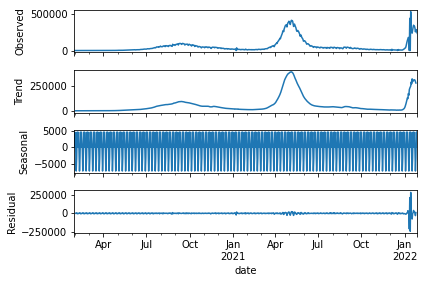

In [6]:
data = data[['date','new_cases','positive_rate','new_deaths','new_tests']]
data['date'] = pd.to_datetime(data['date'])
data.index = data.date
series=data['new_cases']
#print(series)

result = seasonal_decompose(series, model='additive') #, model='multiplicative', period=1
"""
print(result.trend)
print(result.seasonal)
print(result.resid)
print(result.observed)
"""

result.plot()
pyplot.show()

**PATTERN ANOMALIES: Seasonal data with trend and shift**

                 date  new_cases  positive_rate  new_deaths  new_tests
date                                                                  
2020-01-30 2020-01-30        1.0         0.0000         0.0        0.0
2020-01-31 2020-01-31        0.0         0.0000         0.0        0.0
2020-02-01 2020-02-01        0.0         0.0000         0.0        0.0
2020-02-02 2020-02-02        1.0         0.0000         0.0        0.0
2020-02-03 2020-02-03        1.0         0.0000         0.0        0.0
...               ...        ...            ...         ...        ...
2022-01-24 2022-01-24   255874.0         0.1648       614.0  1474753.0
2022-01-25 2022-01-25   285914.0         0.1631       665.0  1807100.0
2022-01-26 2022-01-26   286384.0         0.1637       573.0  1769745.0
2022-01-27 2022-01-27   251209.0         0.1606       627.0  1594070.0
2022-01-28 2022-01-28   235532.0         0.0000       871.0  1582307.0

[730 rows x 5 columns]
[[1.000000e+00 0.000000e+00 0.000000e+00 0.000000e+00

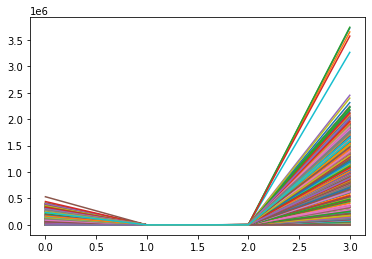

In [7]:
print(data)
d = data[['new_cases','positive_rate','new_deaths','new_tests']]
a = np.array(d)
a = a[:,0:4] #+ 40
print(a)
pyplot.plot(a.T)
np.set_printoptions(False)


### UTILITY FUNCTION FOR PLOTTING ###

In [8]:
def plot_history(ax, i, is_anomaly, window_len, color='blue', **pltargs):
    
    posrange = np.arange(0,i)
    
    ax.fill_between(posrange[window_len:], 
                    pltargs['low'][1:], pltargs['up'][1:], 
                    color=color, alpha=0.2)
    if is_anomaly:
        ax.scatter(i-1, pltargs['original'][-1], c='red')
    else:
        ax.scatter(i-1, pltargs['original'][-1], c='black')
    ax.scatter(i-1, pltargs['smooth'][-1], c=color)
    
    ax.plot(posrange, pltargs['original'][1:], '.k')
    ax.plot(posrange[window_len:], 
            pltargs['smooth'][1:], color=color, linewidth=3)
    
    if 'ano_id' in pltargs.keys():
        if pltargs['ano_id'].sum()>0:
            not_zeros = pltargs['ano_id'][pltargs['ano_id']!=0] -1
            ax.scatter(not_zeros, pltargs['original'][1:][not_zeros], 
                       c='red', alpha=1.)

### SIMULATE PROCESS REAL-TIME AND CREATE GIF ###

(4, 730)


100%|█████████▉| 730/731 [00:35<00:00, 20.65it/s]


IndexError: ignored

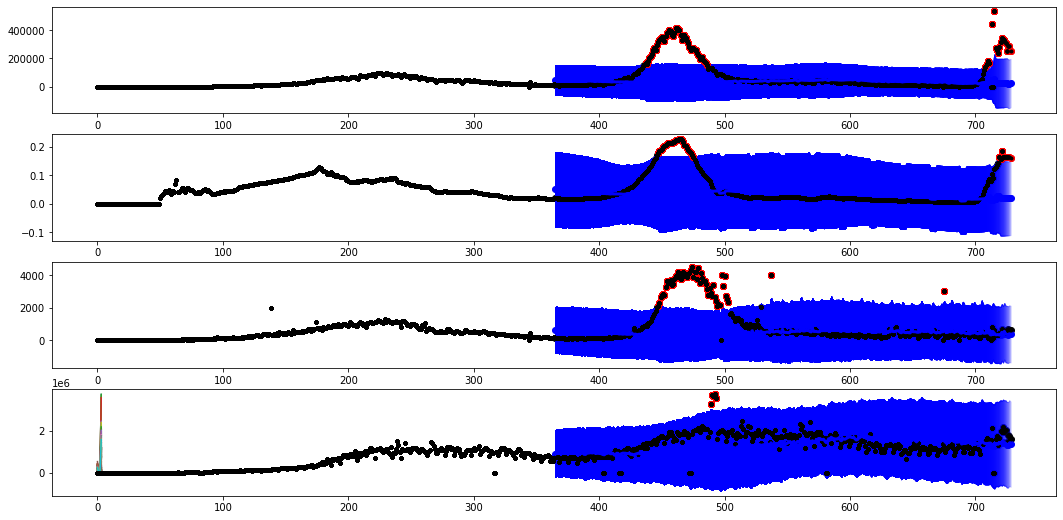

In [9]:
#n_series, timesteps = 3, 3 #4, 200
#window_len = 2 #24*5



fig = pyplot.figure(figsize=(18,9))
camera = Camera(fig)

a=a.T
print(a.shape)
n_series, timesteps = 4, 730
window_len = 73*5

axes = [pyplot.subplot(n_series,1,ax+1) for ax in range(n_series)]
series = defaultdict(partial(np.ndarray, shape=(n_series,1), dtype='float32'))
recovered = np.copy(a)
#print(recovered)

pyplot.plot(a)
np.set_printoptions(False)

#print(tqdm(range(timesteps+1), total=(timesteps+1))

#for i in tqdm(range(timesteps+1), total=(timesteps+1)):
#  print(i)
#  print(a[:,[i]])

#print (series['original'].shape)


for i in tqdm(range(timesteps+1), total=(timesteps+1)):
    
    if i>window_len:
    
        smoother = DecomposeSmoother(smooth_type='convolution', periods=24,
                                     window_len=window_len, window_type='ones')
        smoother.smooth(series['recovered'][:,-window_len:])

        series['smooth'] = np.hstack([series['smooth'], smoother.smooth_data[:,[-1]]]) 

        _low, _up = smoother.get_intervals('sigma_interval', n_sigma=4)
        series['low'] = np.hstack([series['low'], _low[:,[-1]]])
        series['up'] = np.hstack([series['up'], _up[:,[-1]]])

        is_anomaly = np.logical_or(
            series['original'][:,-1] > series['up'][:,-1], 
            series['original'][:,-1] < series['low'][:,-1]
        ).reshape(-1,1)
        
        if is_anomaly.any():
            ano_series = np.where(is_anomaly)[0]
            series['ano_id'] = np.hstack([series['ano_id'], is_anomaly*i]).astype(int)
            recovered[ano_series,i] = smoother.smooth_data[ano_series,[-1]]
            
        for s in range(n_series):
            pltargs = {k:v[s,:] for k,v in series.items()}
            plot_history(axes[s], i, is_anomaly[s], window_len, 
                         **pltargs)

        camera.snap()
        
    if i>=timesteps:
        continue
    
    series['original'] = np.hstack([series['original'], a[:,[i]]])
    series['recovered'] = np.hstack([series['recovered'], recovered[:,[i]]])
    

print('CREATING GIF...')  # it may take a few seconds
camera._photos = [camera._photos[-1]] + camera._photos
animation = camera.animate()
animation.save('animation4.gif')
pyplot.close(fig)
print('DONE')


### PLOT FINAL RESULT ###

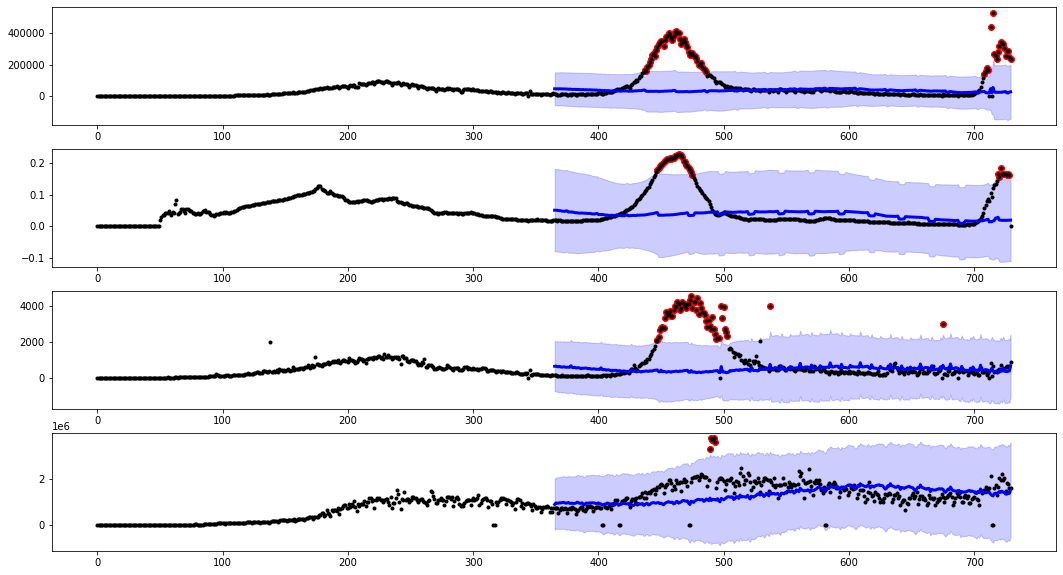

In [10]:
fig = pyplot.figure(figsize=(18,10))
axes = [pyplot.subplot(n_series,1,ax+1) for ax in range(n_series)]

for i,ax in enumerate(axes):
    
    posrange = np.arange(window_len,timesteps)
    
    ax.plot(series['original'][i,1:], '.k')
    ax.plot(posrange, series['smooth'][i,1:], c='blue', linewidth=3)
    
    ax.fill_between(posrange, 
                    series['low'][i,1:], series['up'][i,1:], 
                    color='blue', alpha=0.2)
    
    ano_id = series['ano_id'][i][series['ano_id'][i] != 0] -1
    
    if len(ano_id)>0:
        ax.scatter(ano_id, series['original'][i,1:][ano_id], 
                   c='red', alpha=1.)